In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import pickle
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from flowpm.tfpower import linear_matter_power
import jax
from flowpm import tfpm
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power

Populating the interactive namespace from numpy and matplotlib


In [2]:
box_size=128.     # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
nsteps=40
B=2

In [3]:
cosmology = flowpm.cosmology.Planck15()

In [4]:
stages = np.linspace(0.1, 1., nsteps, endpoint=True)

# Create some initial conditions
k = tf.constant(np.logspace(-4, 1, 512), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(
      [nc, nc, nc],
      [box_size, box_size, box_size],
      pk_fun,
      batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


In [5]:
 # Run the Nbody
states2 = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=B,
                    return_intermediate_states=True)

In [6]:
PGD_param=pickle.load( open("/global/u1/d/dlan/flowpm/notebooks/pgd_params/pgd_params_2_1_40.pkl", "rb" ) )

In [7]:
alpha0=PGD_param['alpha0']
mu=PGD_param['mu']
kl=PGD_param['kl']/(nc*B/ box_size)
ks=PGD_param['ks']/(nc*B/ box_size)

In [8]:
cosmo=jc.Planck15()

In [9]:
# alpha=alpha0*states2[-1][0]**mu
# dx=tfpm.PGD_correction(states2[-1][1],[nc,nc,nc],alpha,kl,ks, pm_nc_factor=B)
# new_state= states2[-1][1][0]+dx
# final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
# final_field=tf.reshape(final_field, [nc, nc, nc])
# k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
#                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)
# pk_jax=power.nonlinear_matter_power(cosmo, k, states2[-1][0])

In [10]:
# final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states2[-1][1][0])
# final_field1=tf.reshape(final_field1, [nc, nc, nc])
# k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
#                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)


In [ ]:
pk_array=[]
pk_array1=[]
pk_jax=[]
for i in range(len(states2)):
    print(i)
    alpha=alpha0*states2[i][0]**mu
    dx=tfpm.PGD_correction(states2[i][1],[nc,nc,nc],alpha,kl,ks,pm_nc_factor=B)
    new_state= states2[i][1][0]+dx
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states2[i][1][0])
    final_field1=tf.reshape(final_field1, [nc, nc, nc])
    k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)

    pk_array.append(power_spectrum)
    pk_array1.append(power_spectrum1)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, states2[i][0]))

In [12]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

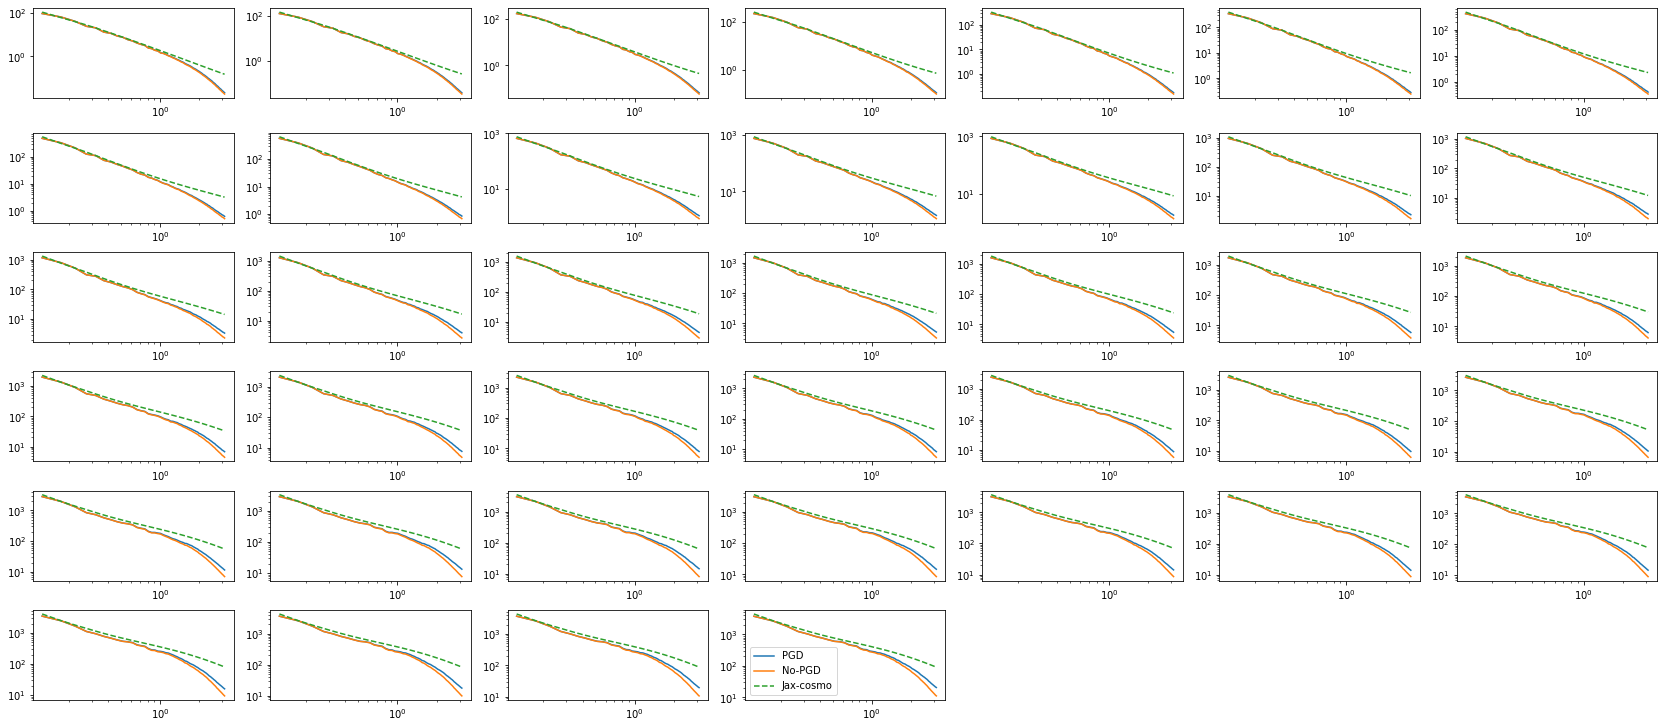

In [14]:
figsize = (23, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 7
rows =6
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(pk_array))
# for ax, p in zip(axs, pk_array2):
#     #ax.set_title('markevery=%s' % str(case))
#     ax.loglog(k, p,label='Dif. Sim. B=2 ')
for ax, pi in zip(axs, pk_array):
    ax.loglog(k, pi,label='PGD')
for ax, px in zip(axs, pk_array1):
    ax.loglog(k, px,label='No-PGD')
for ax, pj in zip(axs, pk_jax):
    ax.loglog(k, pj,'--',label='Jax-cosmo')
legend(loc='lower left')
#fig.savefig('full_figure_B1.png',dpi=250)